In [1]:
import pandas as pd

In [25]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore', 'Year', 'Month', 'Weekday',
       'Hour', 'Minute', '15minReturn', '15minrange', 'Volchange', 'Ret_MACD',
       'Ret_Signal Line', 'Ret_Histogram', 'Vol_MACD', 'Vol_Signal Line',
       'Vol_Histogram', 'Volatility_5', 'Volatility_10', 'Volatility_20',
       'Volume_Z', 'Price_Z', 'Return_Z', 'Z_Close_MA_20'],
      dtype='object')

In [6]:
def macd(price_series, short_window=5, long_window=34, signal_window=5):
    # 1. Calculate EMAs
    short_ema = price_series.ewm(span=short_window, adjust=False).mean()
    long_ema = price_series.ewm(span=long_window, adjust=False).mean()

    # 2. MACD Line
    macd_line = short_ema - long_ema

    # 3. Signal Line (EMA of MACD)
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    # 4. Histogram (MACD - Signal)
    macd_hist = macd_line - signal_line

    # Return as a DataFrame
    return pd.DataFrame({
        "MACD": macd_line,
        "Signal Line": signal_line,
        "Histogram": macd_hist
    })

In [162]:
def weighted_moving_average(series, period):
    weights = np.arange(1, period + 1)
    return series.rolling(period).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

def hull_moving_average(series, period):
    half_length = int(period / 2)
    sqrt_length = int(np.sqrt(period))

    wma_half = weighted_moving_average(series, half_length)
    wma_full = weighted_moving_average(series, period)

    hull_series = 2 * wma_half - wma_full
    hma = weighted_moving_average(hull_series, sqrt_length)

    return hma

In [96]:
def process_stock_data(csv_url):
    # Load and prepare data
    df = pd.read_csv(csv_url)
    df['Open time'] = pd.to_datetime(df['Open time'])  # Ensure datetime format
    df.set_index('Open time', inplace=True)

    df['Year'] = df.index.year         # Extracts year as integer (e.g. 2020)
    df['Month'] = df.index.month       # Extracts month as integer (1–12)
    df['Weekday'] = df.index.weekday   # Monday = 0, Sunday = 6
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute

    df['15minReturn'] = df['Close'] / df['Close'].shift(1) - 1
    df['15minrange'] = df['High'] - df['Low']
    df['Volchange'] = df['Volume'] / (df['Volume'].shift(1) + 1e-8) - 1

    # Calculate MACD and join to original DataFrame
    macd_r = macd(df["15minReturn"]).add_prefix("Ret_")
    df = df.join(macd_r)
    
    macd_v = macd(df["Volchange"]).add_prefix("Vol_")
    df = df.join(macd_v)

    # 5-day rolling volatility (daily returns)
    df['Volatility_5'] = df['15minReturn'].rolling(window=5).std()

    # 10-day rolling volatility
    df['Volatility_10'] = df['15minReturn'].rolling(window=10).std()

    # 20-day rolling volatility
    df['Volatility_20'] = df['15minReturn'].rolling(window=20).std()

    # Volume Z-score over past 20 days
    df['Volume_Z'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()

    # Price Z-score (on Close) over past 20 days
    df['Price_Z'] = (df['Close'] - df['Close'].rolling(20).mean()) / df['Close'].rolling(20).std()

    # Return Z-score over past 20 days
    df['Return_Z'] = (df['15minReturn'] - df['15minReturn'].rolling(20).mean()) / df['15minReturn'].rolling(20).std()

    ma_20 = df['Close'].rolling(20).mean()
    ma_std_20 = df['Close'].rolling(20).std()
    df['Z_Close_MA_20'] = (df['Close'] - ma_20) / ma_std_20

    df.dropna(inplace=True)
    
    return df

In [21]:
import numpy as np

def generate_volatility_labels(df, lookahead=12, n_classes=3):
    df = df.copy()

    # Compute log returns
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Calculate rolling future volatility (std of log returns)
    df['future_vol'] = (
        df['log_return']
        .shift(-lookahead + 1)  # Shift so we're looking forward
        .rolling(window=lookahead)
        .std()
    )

    # Drop rows with NaNs due to rolling and shifting
    df = df.iloc[:-lookahead]

    # Quantile binning to create classes
    df['volatility_class'] = pd.qcut(
        df['future_vol'],
        q=n_classes,
        labels=range(n_classes)
    )

    return df


In [116]:
df = process_stock_data("/Users/rong/Desktop/btc_15m_data_2018_to_2025.csv")
df = generate_volatility_labels(df, lookahead=12, n_classes=3)

In [117]:
df.dropna()

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,...,Volatility_5,Volatility_10,Volatility_20,Volume_Z,Price_Z,Return_Z,Z_Close_MA_20,log_return,future_vol,volatility_class
Open time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 07:45:00,13644.97,13659.97,13555.02,13570.35,43.920484,2018-01-01 07:59:59.999,5.972011e+05,814,21.261855,2.893379e+05,...,0.004168,0.005224,0.005548,-1.296994,-0.082557,-1.149040,-0.082557,-0.005482,0.006098,2
2018-01-01 08:00:00,13569.98,13665.00,13520.00,13656.23,58.542067,2018-01-01 08:14:59.999,7.948098e+05,919,20.562018,2.791373e+05,...,0.005004,0.005533,0.005403,-0.787024,0.566261,1.024452,0.566261,0.006309,0.005893,2
2018-01-01 08:15:00,13656.23,13735.24,13610.27,13632.89,58.900513,2018-01-01 08:29:59.999,8.054309e+05,869,34.862743,4.767699e+05,...,0.004946,0.005540,0.005091,-0.699760,0.333512,-0.389072,0.333512,-0.001711,0.008687,2
2018-01-01 08:30:00,13614.33,13649.96,13400.00,13434.71,104.766871,2018-01-01 08:44:59.999,1.413295e+06,1204,46.829395,6.318254e+05,...,0.007500,0.007317,0.005996,0.696324,-1.307953,-2.386897,-1.307953,-0.014644,0.009194,2
2018-01-01 08:45:00,13415.00,13508.69,13414.76,13499.99,49.604102,2018-01-01 08:59:59.999,6.684083e+05,741,20.555540,2.770044e+05,...,0.008450,0.006324,0.005897,-0.888301,-0.838635,0.764426,-0.838635,0.004847,0.008691,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-16 20:00:00,108652.01,108693.21,108428.00,108646.31,241.133820,2025-06-16 20:14:59.999,2.617901e+07,38180,130.196620,1.413418e+07,...,0.002079,0.001560,0.001349,0.935354,1.506242,-0.398364,1.506242,-0.000052,0.003530,2
2025-06-16 20:15:00,108646.30,108648.68,108509.66,108626.77,93.391940,2025-06-16 20:29:59.999,1.013982e+07,19332,39.826400,4.323606e+06,...,0.001511,0.001515,0.001309,-0.924183,1.316000,-0.541088,1.316000,-0.000180,0.003586,2
2025-06-16 20:30:00,108626.77,108757.32,108559.89,108737.31,87.088030,2025-06-16 20:44:59.999,9.461555e+06,14678,53.431900,5.805273e+06,...,0.001429,0.001473,0.001314,-0.970460,1.408247,0.356865,1.408247,0.001017,0.003632,2


In [118]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [119]:
cats=['Month','Weekday','Hour']
conts=['Year','15minReturn', '15minrange', 'Volchange', 'Volatility_5', 'Volatility_10', 'Volatility_20','Volume_Z', 'Price_Z', 'Return_Z', 'Z_Close_MA_20','Vol_Histogram','Ret_Histogram']
dep="volatility_class"

In [125]:
df['Month'] = df['Month'].astype('category')
df['Weekday'] = df['Weekday'].astype('category')
df['Hour'] = df['Hour'].astype('category')

df['Month'] = pd.Categorical(df['Month'], categories=range(1, 13), ordered=True)
df['Weekday'] = pd.Categorical(df['Weekday'], categories=[0,1,2,3,4,5,6], ordered=True)
df['Hour'] = pd.Categorical(df['Hour'], categories=range(24), ordered=True)


In [ ]:
df

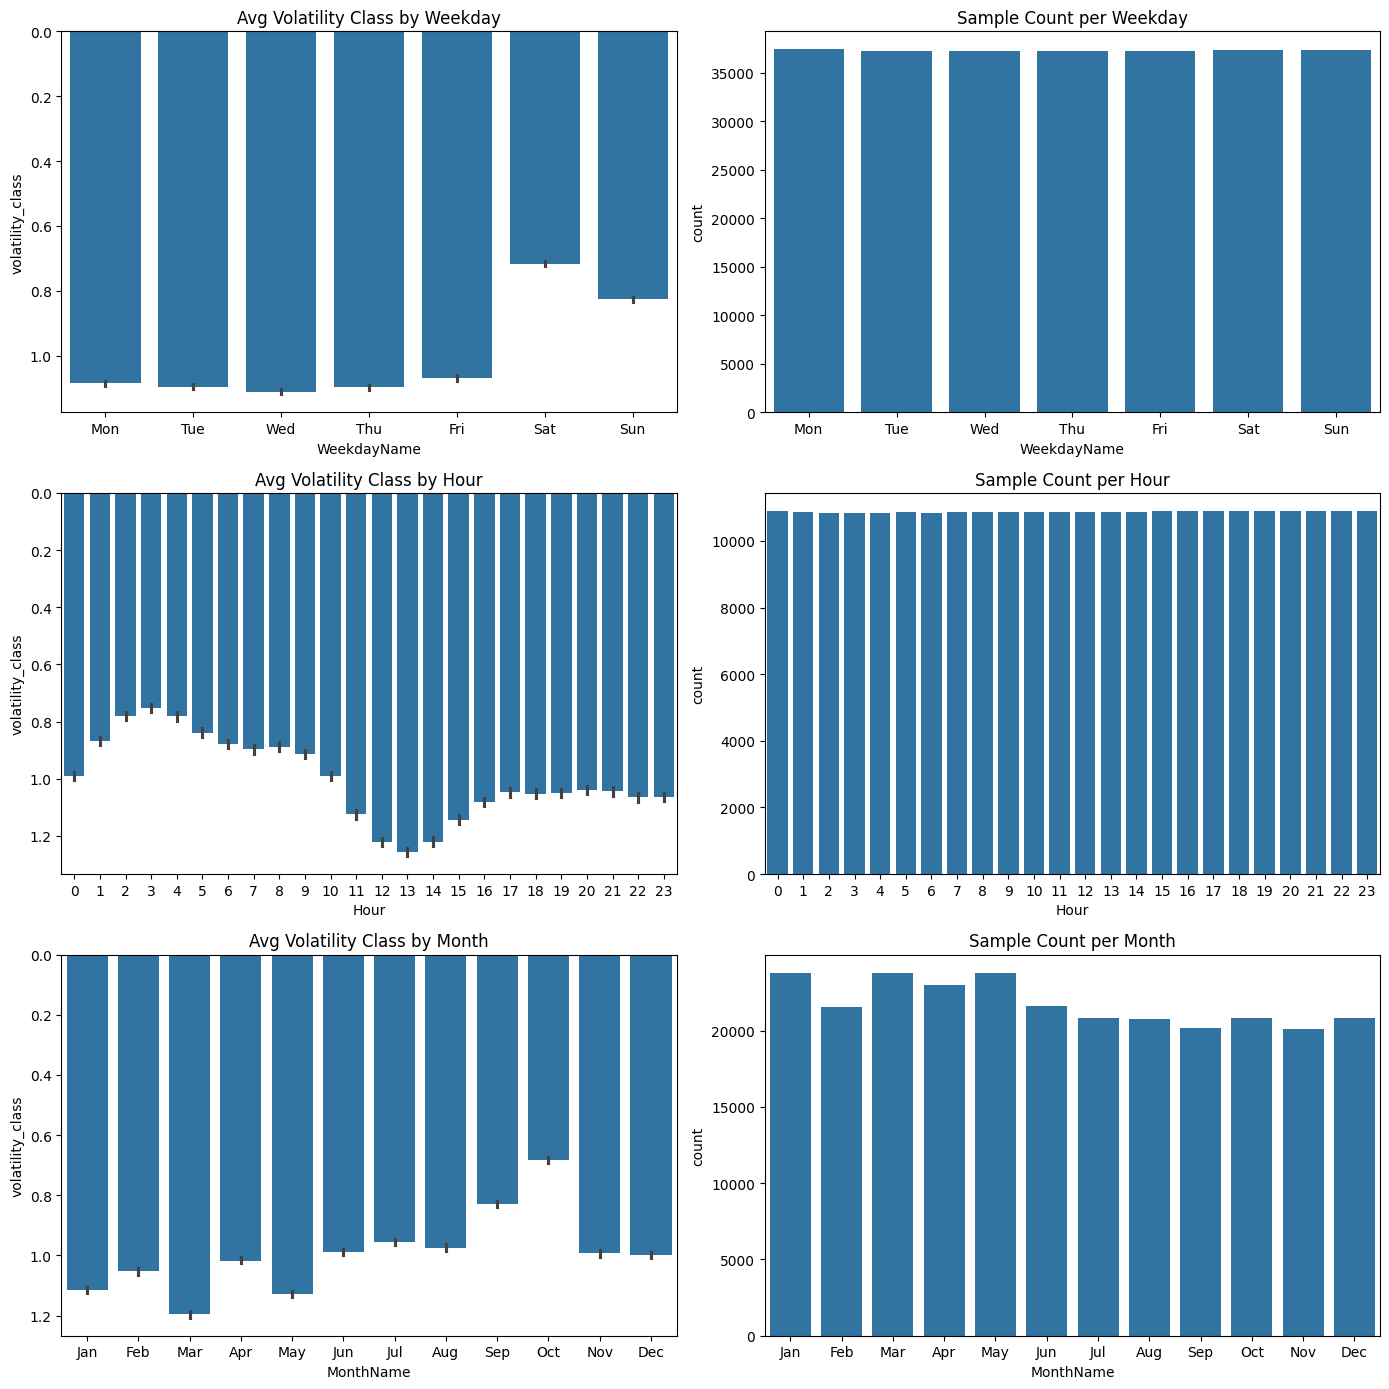

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Optional readable names ---
df['WeekdayName'] = df['Weekday'].map({
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'
})
df['MonthName'] = df['Month'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
})

# Create a 3-row plot: Weekday, Hour, Month
fig, axs = plt.subplots(3, 2, figsize=(14, 14))

# --- Weekday plots ---
sns.barplot(data=df, x='WeekdayName', y='volatility_class', 
            order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ax=axs[0, 0])
axs[0, 0].set_title('Avg Volatility Class by Weekday')

sns.countplot(data=df, x='WeekdayName', 
              order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ax=axs[0, 1])
axs[0, 1].set_title('Sample Count per Weekday')

# --- Hour plots ---
sns.barplot(data=df, x='Hour', y='volatility_class', ax=axs[1, 0])
axs[1, 0].set_title('Avg Volatility Class by Hour')

sns.countplot(data=df, x='Hour', ax=axs[1, 1])
axs[1, 1].set_title('Sample Count per Hour')

# --- Month plots ---
sns.barplot(data=df, x='MonthName', y='volatility_class', 
            order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ax=axs[2, 0])
axs[2, 0].set_title('Avg Volatility Class by Month')

sns.countplot(data=df, x='MonthName', 
              order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ax=axs[2, 1])
axs[2, 1].set_title('Sample Count per Month')

plt.tight_layout()
plt.show()


In [129]:
trn_df = df.iloc[:200000].copy()
val_df = df.iloc[200000:230000]
test_df = df.iloc[230000:]

In [122]:
cap_value = 155.31
df['Volchange'] = df['Volchange'].clip(upper=cap_value)


In [134]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed()

trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

/var/folders/9h/0y5x8lz50_91q3vx4bly1x_40000gn/T/ipykernel_1248/449253077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)


In [135]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [136]:
preds = val_xs.Month==6

In [137]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.7318333333333333

In [23]:
preds = val_xs.Vol_Histogram>0.095

In [59]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.7322

In [64]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].astype(float).std() * tot

In [61]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [139]:
score(trn_xs["Weekday"], trn_y, 5)

np.float64(0.817583465693106)

In [140]:
score(trn_xs["Z_Close_MA_20"], trn_y, 0.01)

np.float64(0.8195198094040851)

In [141]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Weekday")

(np.int8(4), np.float64(0.8120630747566063))

In [142]:
def min_col_fast(df, nm, n_splits=100):
    col, y = df[nm], df[dep]
    candidates = np.percentile(col.dropna(), np.linspace(1, 99, n_splits))
    scores = np.array([score(col, y, s) for s in candidates])
    idx = scores.argmin()
    return candidates[idx], scores[idx]


In [145]:
cols = cats+conts
{o:min_col_fast(trn_df, o) for o in cols}

{'Month': (np.float64(5.0), np.float64(0.8113652296512678)),
 'Weekday': (np.float64(4.0), np.float64(0.8120630747566063)),
 'Hour': (np.float64(9.0), np.float64(0.8140853220240014)),
 'Year': (np.float64(2022.0), np.float64(0.7927633327231391)),
 '15minReturn': (np.float64(-0.003142546915880874),
  np.float64(0.7794557459291142)),
 '15minrange': (np.float64(54.630000000000464),
  np.float64(0.7352333229779985)),
 'Volchange': (np.float64(1.3494017668854268), np.float64(0.817686269628157)),
 'Volatility_5': (np.float64(0.0022556280869564177),
  np.float64(0.6941656952711934)),
 'Volatility_10': (np.float64(0.0023614930902877023),
  np.float64(0.6808578307702261)),
 'Volatility_20': (np.float64(0.002378722432313636),
  np.float64(0.6817240849170523)),
 'Volume_Z': (np.float64(1.3914268160248753), np.float64(0.8157993603660301)),
 'Price_Z': (np.float64(-1.9541859090622737), np.float64(0.8165293390764197)),
 'Return_Z': (np.float64(-1.5990129451968247), np.float64(0.81682485579127)),
 'Z

In [149]:
trn_y.isna().sum()

np.int64(0)

In [147]:
mask = trn_y.notna()
trn_y = trn_y[mask]
trn_xs = trn_xs[mask]

In [148]:
trn_xs = trn_xs[trn_y.notna()]
trn_y = trn_y.dropna()

In [93]:
# Add a helper column to inspect the denominator
df['Volume_prev'] = df['Volume'].shift(1)

# Recreate the inf_rows with context
inf_rows = df[np.isinf(df['Volchange'])][['Volume', 'Volume_prev', 'Volchange']]


In [94]:
inf_rows

,Volume,Volume_prev,Volchange
Open time,,,
2019-06-07 22:15:00,306.602845,0.0,inf
2021-02-11 05:00:00,900.171534,0.0,inf
2023-03-24 14:00:00,2950.809520,0.0,inf


In [150]:
trn_xs.describe().T.sort_values('max', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
Vol_Histogram,199989.0,-0.000003,1.483563e+08,-1.379467e+10,-0.074525,-0.020176,0.046017,5.433237e+10
15minrange,199989.0,109.364000,1.522182e+02,0.000000e+00,24.680000,53.820000,137.800000,7.133210e+03
Year,199989.0,2020.381976,1.654023e+00,2.018000e+03,2019.000000,2020.000000,2022.000000,2.023000e+03
Volchange,199989.0,0.151664,1.106242e+00,-1.000000e+00,-0.265304,-0.033996,0.302835,1.553100e+02
Hour,199989.0,11.512068,6.922771e+00,0.000000e+00,6.000000,12.000000,18.000000,2.300000e+01
Month,199989.0,5.318638,3.388806e+00,0.000000e+00,2.000000,5.000000,8.000000,1.100000e+01
Weekday,199989.0,2.998360,2.001187e+00,0.000000e+00,1.000000,3.000000,5.000000,6.000000e+00
Volume_Z,199989.0,0.000525,1.069555e+00,-3.153860e+00,-0.704435,-0.302928,0.397707,4.246767e+00
Return_Z,199989.0,-0.003797,9.830957e-01,-4.233125e+00,-0.602069,-0.004601,0.597977,4.228067e+00
Price_Z,199989.0,0.027155,1.277493e+00,-4.229515e+00,-0.918805,0.057831,0.980782,4.184884e+00


In [156]:
from sklearn.ensemble import RandomForestClassifier

Mean Absolute Error: 0.3940


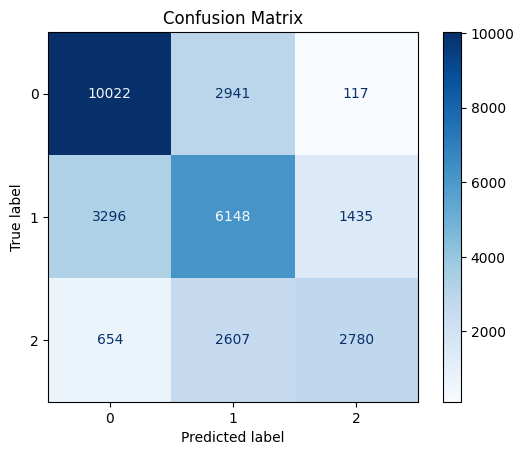

In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fit Random Forest with all CPU cores
rf = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # use all cores
)

rf.fit(trn_xs, trn_y)

# Evaluate
preds = rf.predict(val_xs)
mae = mean_absolute_error(val_y, preds)
print(f"Mean Absolute Error: {mae:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(val_y, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


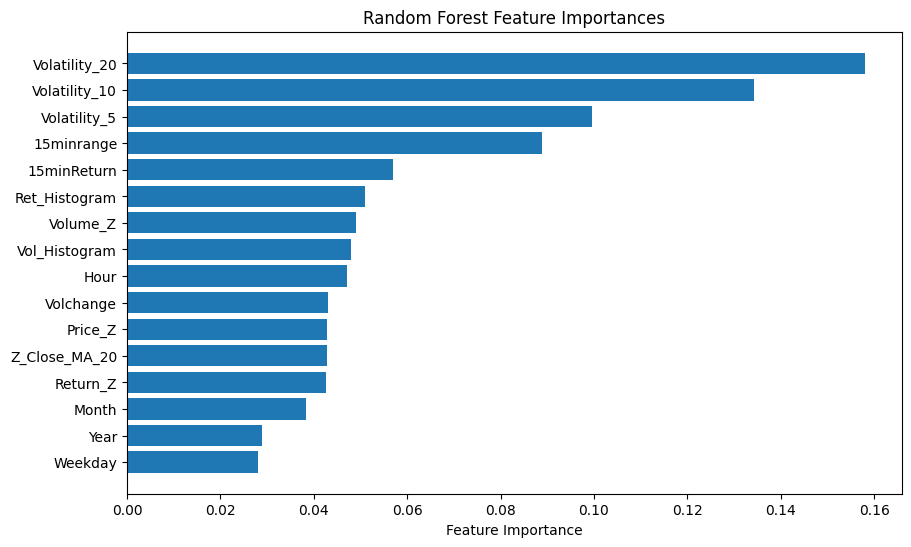

In [160]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = rf.feature_importances_
feature_names = trn_xs.columns

# Create a DataFrame and sort
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict on the training data (or use a validation/test set instead)
preds = m.predict(trn_xs)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(trn_y, preds)

# Step 3: Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')  # 'd' to show integers
plt.title("Confusion Matrix")
plt.show()

In [153]:
!pip install graphviz

  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)


In [154]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

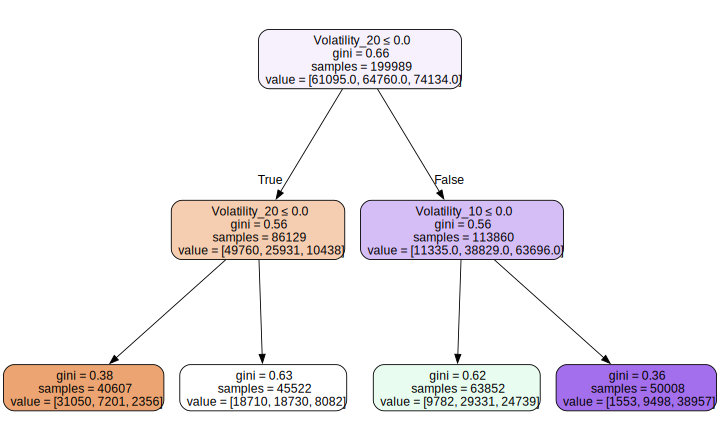

In [155]:
draw_tree(m, trn_xs, size=10)

In [37]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [91]:
mean_absolute_error(val_y, m.predict(val_xs))

0.25609756097560976

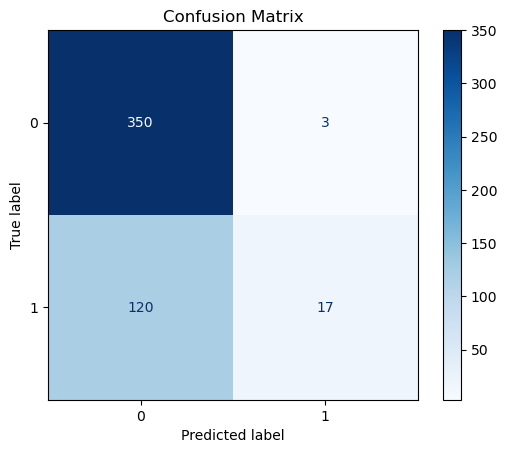

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict on the training data (or use a validation/test set instead)
preds = m.predict(trn_xs)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(trn_y, preds)

# Step 3: Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')  # 'd' to show integers
plt.title("Confusion Matrix")
plt.show()

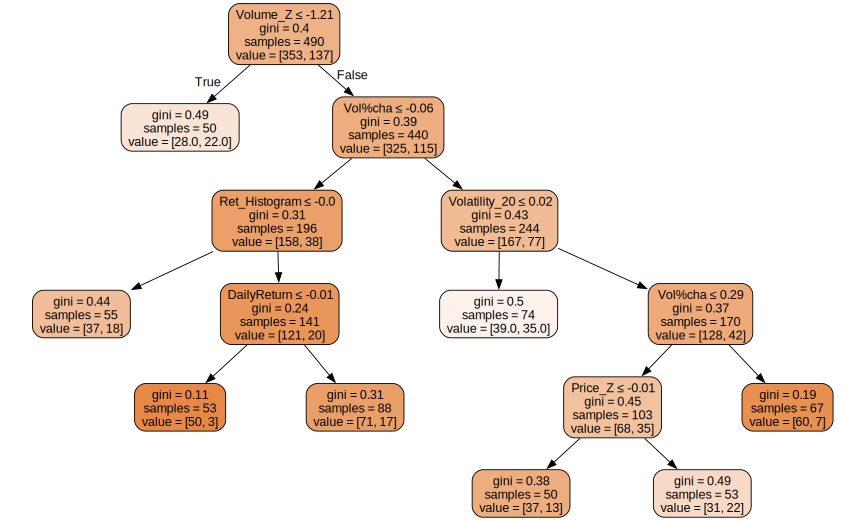

In [83]:
n = DecisionTreeClassifier(min_samples_leaf=50)
n.fit(trn_xs, trn_y)
draw_tree(n, trn_xs, size=12)

In [85]:
mean_absolute_error(val_y, n.predict(val_xs))

0.24390243902439024

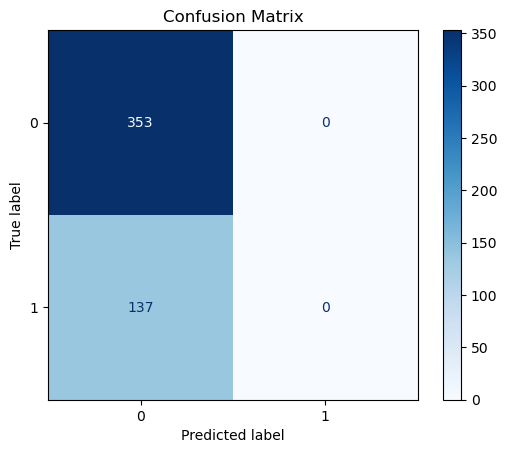

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict on the training data (or use a validation/test set instead)
preds = m.predict(trn_xs)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(trn_y, preds)

# Step 3: Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')  # 'd' to show integers
plt.title("Confusion Matrix")
plt.show()

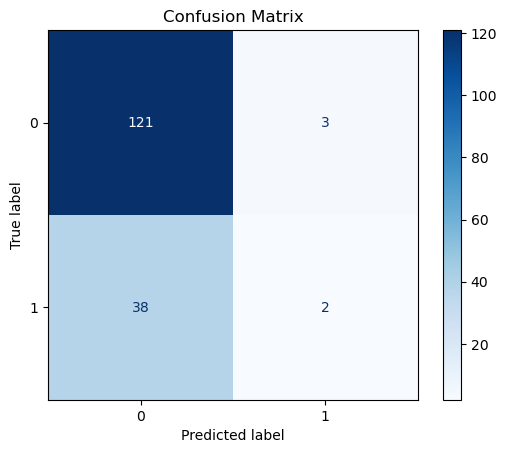

In [117]:
from sklearn.ensemble import RandomForestClassifier
o = RandomForestClassifier(n_estimators=1000, class_weight="balanced")
o.fit(trn_xs, trn_y)

mean_absolute_error(val_y, n.predict(val_xs))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict on the training data (or use a validation/test set instead)
preds = o.predict(val_xs)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(val_y, preds)

# Step 3: Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')  # 'd' to show integers
plt.title("Confusion Matrix")
plt.show()

# draw_tree(n, trn_xs, size=12)

In [101]:
trn_xs

,Month,Weekday,Year,Vol%cha,DailyReturn,Volatility_5,Volatility_10,Volatility_20,Volume_Z,Price_Z,Return_Z,Z_Close_MA_20,Vol_Histogram,Ret_Histogram
Date,,,,,,,,,,,,,,
2020-10-26,9,0,2020,-0.141580,-0.009629,0.011168,0.013087,0.024603,-1.222705,-1.520122,-0.288991,-1.520122,-0.024938,-0.001414
2020-10-22,9,3,2020,-0.279158,-0.014766,0.015336,0.028283,0.024839,-1.114983,-0.900071,-0.614014,-0.900071,-0.054932,-0.005046
2021-06-02,5,2,2021,-0.277548,-0.011602,0.030510,0.027917,0.027333,-0.143483,0.755860,-0.342177,0.755860,-0.072828,-0.003335
2021-09-03,8,4,2021,0.155960,0.012458,0.020397,0.016293,0.019448,-0.639844,-0.996763,1.019890,-0.996763,0.007786,0.002199
2020-09-24,8,3,2020,0.018683,-0.010627,0.019744,0.021950,0.029083,-1.103298,-0.389877,-0.142788,-0.389877,-0.005562,-0.003604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-14,7,4,2020,0.189672,0.029658,0.031102,0.041374,0.043035,-1.228195,0.620605,0.494637,0.620605,0.021532,0.006293
2022-01-07,0,4,2022,-0.090753,-0.000988,0.008578,0.009061,0.009475,-0.826971,-1.151608,0.300419,-1.151608,-0.032976,-0.000556
2022-03-07,2,0,2022,0.652222,-0.045255,0.018738,0.022967,0.017801,1.241719,-3.395400,-2.440365,-3.395400,0.136433,-0.008495


In [103]:
val_xs

,Month,Weekday,Year,Vol%cha,DailyReturn,Volatility_5,Volatility_10,Volatility_20,Volume_Z,Price_Z,Return_Z,Z_Close_MA_20,Vol_Histogram,Ret_Histogram
Date,,,,,,,,,,,,,,
2022-11-30,10,2,2022,-0.218582,0.000400,0.011525,0.011797,0.022024,-0.715589,0.627501,-0.114316,0.627501,-0.034326,0.001872
2021-02-10,1,2,2021,-0.139264,0.002873,0.034107,0.036930,0.038937,-1.308673,-0.593841,0.185394,-0.593841,-0.019774,0.004245
2022-11-10,10,3,2022,0.477703,-0.023549,0.011986,0.013050,0.020906,-0.333048,0.236655,-1.341975,0.236655,0.091024,-0.006375
2022-04-01,3,4,2022,-0.205255,-0.003255,0.018031,0.013934,0.024136,-0.346266,-1.351279,0.084638,-1.351279,0.003315,-0.001697
2022-07-04,6,0,2022,0.141927,-0.017924,0.020096,0.019447,0.019005,0.027841,0.994412,-1.057285,0.994412,-0.038378,-0.007047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,10,1,2022,-0.128531,-0.004568,0.020126,0.025449,0.024424,0.822482,1.893911,-0.337468,1.893911,-0.142225,-0.003077
2022-05-19,4,3,2022,0.643565,0.014190,0.013658,0.016556,0.036525,0.121406,1.056263,0.368425,1.056263,0.093083,0.000134
2022-06-10,5,4,2022,-0.032110,0.011213,0.023872,0.018518,0.017882,-0.016616,0.327934,0.573330,0.327934,-0.053929,-0.000913


In [105]:
val_y

Date
2022-11-30    0
2021-02-10    0
2022-11-10    0
2022-04-01    0
2022-07-04    0
             ..
2022-11-01    0
2022-05-19    0
2022-06-10    0
2021-05-24    0
2022-10-10    0
Name: avoid_entry, Length: 164, dtype: int64

In [107]:
trn_y

Date
2020-10-26    0
2020-10-22    0
2021-06-02    0
2021-09-03    1
2020-09-24    0
             ..
2020-08-14    1
2022-01-07    0
2022-03-07    0
2022-07-07    0
2021-05-07    0
Name: avoid_entry, Length: 490, dtype: int64